# Solving the heat equation using G+Smo
**Author**: Felix Scholz, felix.scholz@jku.at

## Initial definitions and imports
We import the `gismo` namespace from `gismo_cppyy`. It contains all definitions of the G+Smo library.

In [1]:
from gismo_cppyy import gismo

We want to use matplotlib for plotting the data, so we define a function that plots the solution as a color plot over the unit square

In [18]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import copy

def plotfield(field, evaluator, time, ax, n=100):
    evalpoints=evalgrid(field, evaluator, n=n)

    ax.set_title(f"Time: {time}s", loc="left")
    ax.imshow(evalpoints.reshape(n, n), interpolation="bilinear", cmap="coolwarm", vmin=0.0, vmax=.5, extent=[0., 1., 0., 1.])

def evalgrid(field, evaluator, n=100):
    corners = gismo.gsMatrix["real_t"].fromnumpy(np.array([[0., 1.], [0.,1.]]))
    numpoints = gismo.gsVector["int"](2)
    numpoints[0] = n
    numpoints[1] = n
    gismogrid = gismo.gsGridIterator["double", gismo.CUBE, 2](corners, numpoints)

    evaluator.eval(field, gismogrid, 0)
    evalpoints = gismo.gsVector["real_t"](evaluator.allValues()).tonumpy()

    return copy.deepcopy(evalpoints.reshape(n,n))

Note that we have used here the conversion functions `tonumpy()` and `fromnumpy()` in order to convert between G+Smo matrices and numpy arrays.

## Defining the domain and the boundary conditions

For now, our computational domain is the unit square, represented as a quadratic B-spline. 

In [5]:
multipatch = gismo.gsMultiPatch["real_t"](gismo.gsNurbsCreator["real_t"].BSplineSquareDeg(2))

As boundary conditions, we set homogeneous Dirichlet conditions on three sides and a constant negative Neumann boundary condition on the remaining side.

In [6]:
boundarycondition = gismo.gsBoundaryConditions["real_t"]()
neumanncond = gismo.gsFunctionExpr["real_t"] ("-1", 2)
dirichletcond = gismo.gsFunctionExpr["real_t"] ("0", 2)

boundarycondition.addCondition(0, gismo.boundary.west, gismo.condition_type.neumann, neumanncond)
boundarycondition.addCondition(0, gismo.boundary.east, gismo.condition_type.dirichlet, dirichletcond)
boundarycondition.addCondition(0, gismo.boundary.north, gismo.condition_type.dirichlet, dirichletcond)
boundarycondition.addCondition(0, gismo.boundary.south, gismo.condition_type.dirichlet, dirichletcond)
boundarycondition.setGeoMap(multipatch)

## Discretizing the spatial derivatives
We want to use a Galerkin method in space and a finite difference method in time.


### Basis for the isogeometric function space
In order to define the basis of the discrete space that we use for solving, we take the biquadratic tensor product B-spline basis that was used to represent the geometry and we refine it a couple of times.

In [7]:
basis = gismo.gsMultiBasis["real_t"](multipatch, True)

for _ in range(5):
        basis.uniformRefine()

### Assembly of the mass matrix
We need the mass matrix in our time stepping scheme, so we assemble it using a second expression assembler.

In [8]:
A_mass = gismo.gsExprAssembler["real_t"]()
A_mass.setIntegrationElements(basis)

G_mass = A_mass.getMap(multipatch)
u_mass = A_mass.getSpace(basis)

u_mass.setup(boundarycondition, gismo.dirichlet.l2Projection, 0)
A_mass.initSystem()

A_mass.assemble(u_mass*u_mass.tr() * gismo.expr.meas(G_mass))

massMatrix = A_mass.matrix()

The expression assembler `A_mass` assembles a bilinear form based on an expression, in this case `u_mass*u_mass.tr() * gismo.expr.meas(G_mass)`. Here, `u_mass` refers to the discrete function space and `G_mass` represents the geometry mapping. `meas(G_mass)` is its Jacobian determant.

### Assembly of the stiffness matrix and the source vector
In this example, the source function is constant 0 and therefore does not contribute to the right-hand-side. 
However, the Neumann boundary condition is non-zero.

In [9]:
A_stiff = gismo.gsExprAssembler["real_t"]()
A_stiff.setIntegrationElements(basis)

G_stiff = A_stiff.getMap(multipatch)
u_stiff = A_stiff.getSpace(basis)
g_N_stiff = A_stiff.getBdrFunction(G_stiff)

u_stiff.setup(boundarycondition, gismo.dirichlet.l2Projection, 0)
A_stiff.initSystem()

A_stiff.assemble(gismo.expr.igrad(u_stiff, G_stiff) * gismo.expr.igrad(u_stiff, G_stiff).tr() * gismo.expr.meas(G_stiff))
A_stiff.assembleBdr(boundarycondition.get("Neumann"), u_stiff * g_N_stiff.tr() * gismo.expr.nv(G_stiff))

stiffnessmatrix = A_stiff.matrix()
rhs = A_stiff.rhs()

`G_stiff` is an expression representing the geometry mapping, `u_stiff` is an expression representing the discrete function space and `g_N_stiff` is the boundary function. `meas(G_stiff)` refers to the norm of the Jacobian determinant of the geometry mapping.


The expression assembler `A_stiff` assembles the bilinear form and the linear form based based on the expressions.
Here, `igrad(u_stiff, G_stiff)` is short for `grad(u) * jac(G).inv()`. Therefore, the assembled bilinear form  is indeed the stiffness matrix.
The assembler also imposes the strong boundary conditions.

## Solver and initial condition
We will use a sparse LU solver from Eigen to perform the time steps. Of course we can also try out any other solver included in G+Smo. 

In [10]:
solver = gismo.gsSparseSolver["real_t"].LU()

We set the initial temperature distribution to constant 0.

In [20]:
solvector = gismo.gsMatrix["real_t"]()
solvector.setZero(A_stiff.numDofs(), 1);

Let's plot the initial condition. To this end, we create an expression evaluator and an expression for the initial solution and we use the `plotfield` function that we defined above. 


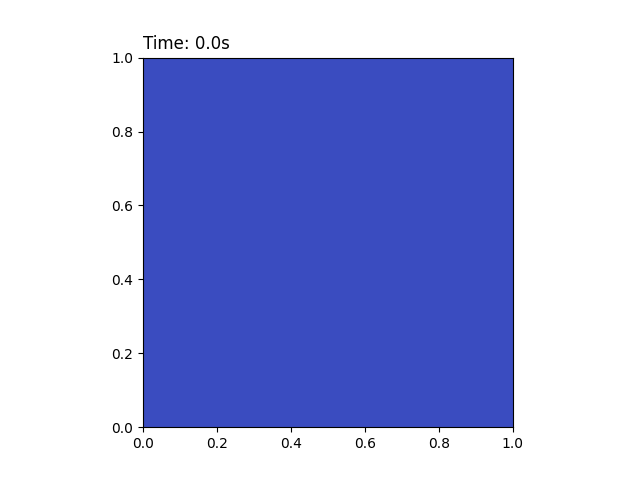

In [21]:
ev = gismo.gsExprEvaluator["real_t"](A_stiff)
u_sol = A_stiff.getSolution(u_stiff, solvector)


fig = plt.figure()
ax = fig.add_subplot(111)
plotfield(field=u_sol, evaluator=ev, time=0.0, ax=ax)

plt.show()

As expected, the temperature is zero everywhere. We will now change this by running our simulation.

## Performing the time stepping
We can now start our time-stepping scheme. We set the end time $T$ as well as the time step $\Delta t$.

Luckily, we only need to compute factorization of the system matrix 
$$
M + \frac{\Delta t}2S
$$
once.

In [13]:
endTime = 1
numSteps = 100
Dt = endTime / (numSteps - 1)

solver.compute(massMatrix + stiffnessmatrix * Dt * 0.5);

We will now iterate over the time steps until we reach the final time. In each step, we update the current solution to be the solution of the linear system
$$
\left(M + \frac{\Delta t}2S\right) u^{i+1} = \Delta tf + \left(M - \frac{\Delta t}2S\right)u^i.
$$
We then use our plot function to visualize the solution at the current time step.

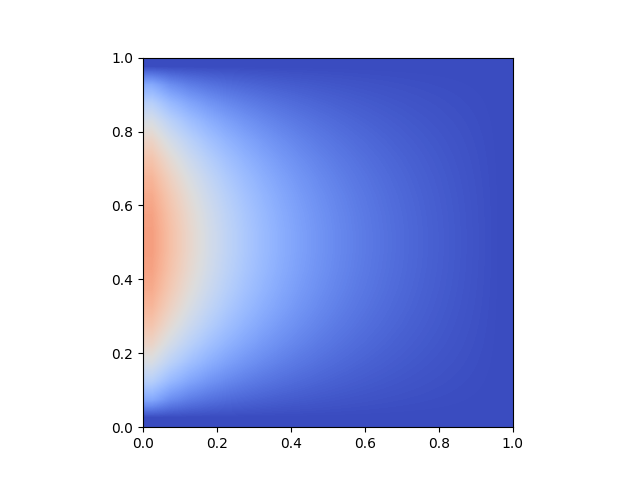

In [24]:
import matplotlib.animation as animation
import time

img_array = []

fig1 = plt.figure()

for step in range(numSteps):
    solvector = solver.solve(rhs * Dt + (massMatrix - stiffnessmatrix * Dt* 0.5) * solvector)

    u_sol = A_stiff.getSolution(u_stiff, solvector)

    img = plt.imshow(evalgrid(field=u_sol, evaluator=ev,n=20),
                     interpolation="bilinear", cmap="coolwarm", vmin=0.0, vmax=.5, extent=[0., 1., 0., 1.], animated=True)
    
    img_array.append([img])


ani = animation.ArtistAnimation(fig1, img_array, interval=500, repeat=True, repeat_delay=2000)
time.sleep(0.1)
plt.show()